Order of Steps:

- Load & Clean Data
- Exploratory Data Analysis (EDA)
    - Class distribution
    - Time & amount histograms
    - Correlation matrix
- Preprocessing
    - Feature scaling
    - Train-test split
- Model Training (Logistic Regression)
- Evaluation & Visualization
- Interpretability (SHAP, LIME)

In [1]:
import pandas as pd

df = pd.read_csv("creditcard.csv")
df = df.drop_duplicates()


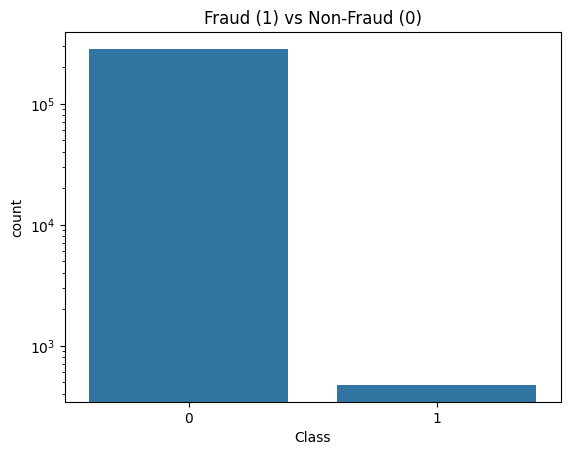

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Class', data=df)
plt.yscale('log')
plt.title("Fraud (1) vs Non-Fraud (0)")
plt.show()


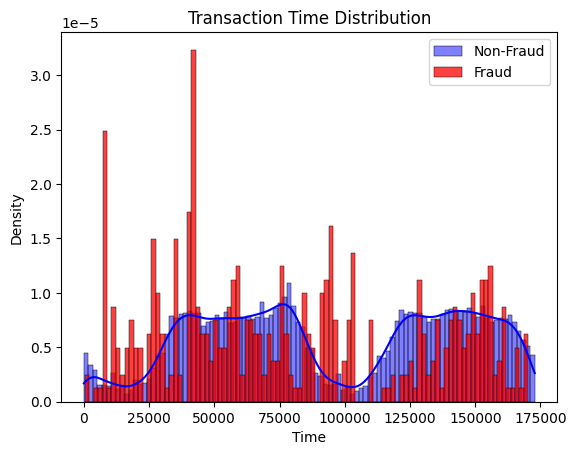

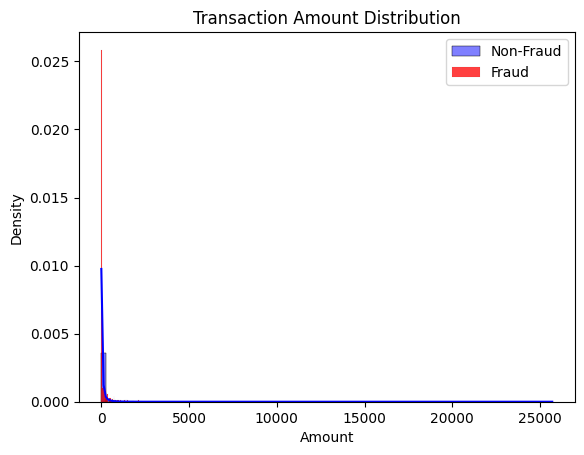

In [3]:
# Time distribution
sns.histplot(df[df['Class'] == 0]['Time'], bins=100, color='blue', label='Non-Fraud', stat='density', kde=True)
sns.histplot(df[df['Class'] == 1]['Time'], bins=100, color='red', label='Fraud', stat='density', kde=False)
plt.title("Transaction Time Distribution")
plt.legend()
plt.show()

# Amount distribution
sns.histplot(df[df['Class'] == 0]['Amount'], bins=100, color='blue', label='Non-Fraud', stat='density', kde=True)
sns.histplot(df[df['Class'] == 1]['Amount'], bins=100, color='red', label='Fraud', stat='density', kde=False)
plt.title("Transaction Amount Distribution")
plt.legend()
plt.show()


### Correlation Matrix (Heatmap)

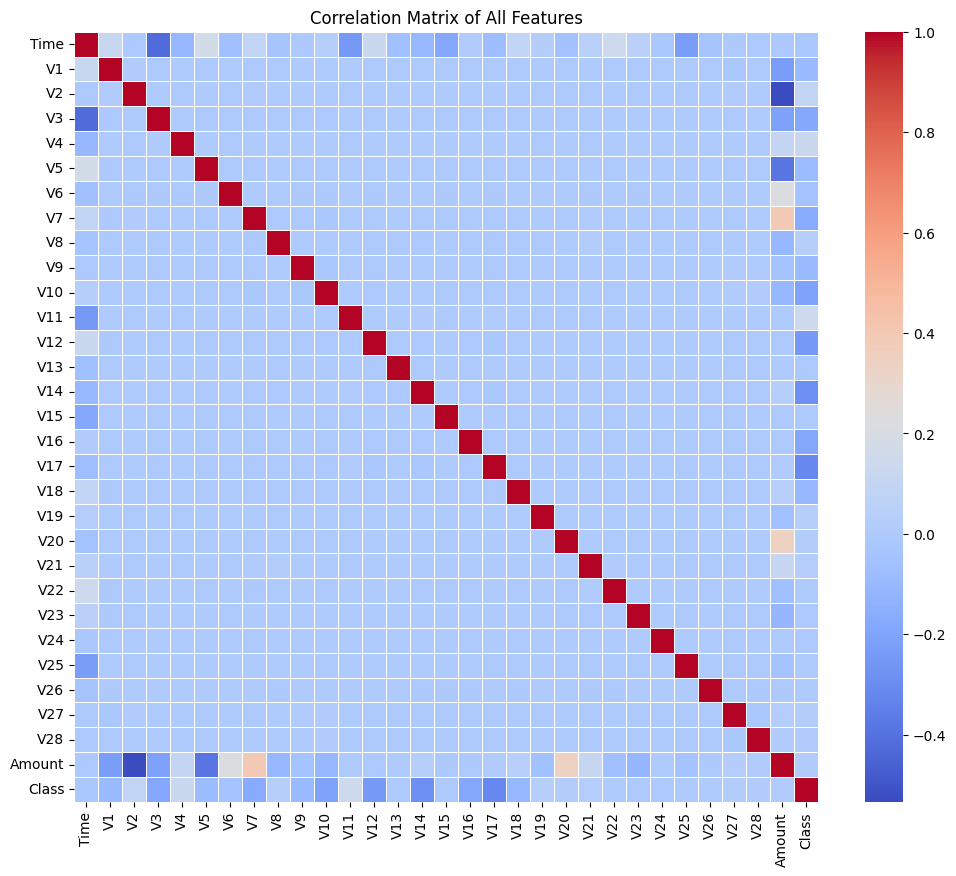

In [4]:
# Compute correlation matrix
corr_matrix = df.corr()

# Plot heatmap of top correlated features with 'Class'
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of All Features")
plt.show()


### Correlation with Target Class Only

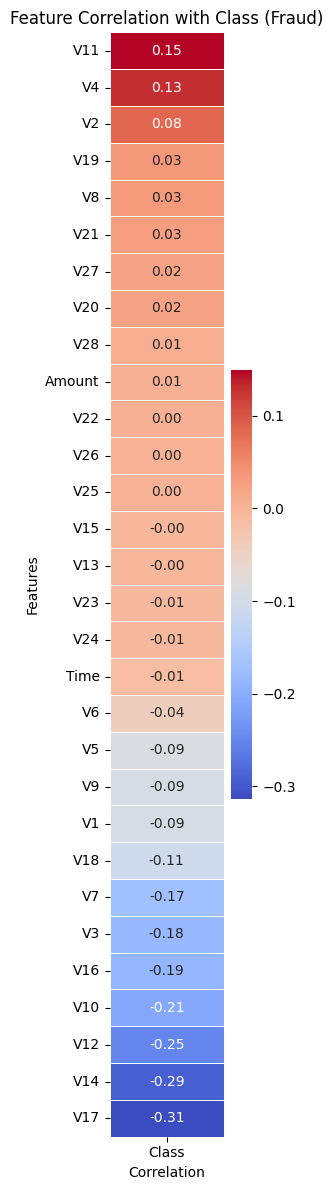

In [5]:
# Correlation of features with 'Class'
corr_with_class = corr_matrix["Class"].drop("Class").sort_values(ascending=False)

# Plot vertical heatmap
plt.figure(figsize=(3, 12))
sns.heatmap(corr_with_class.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar=True)
plt.title("Feature Correlation with Class (Fraud)")
plt.xlabel("Correlation")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


### PCA - for 2D visualization of the data.

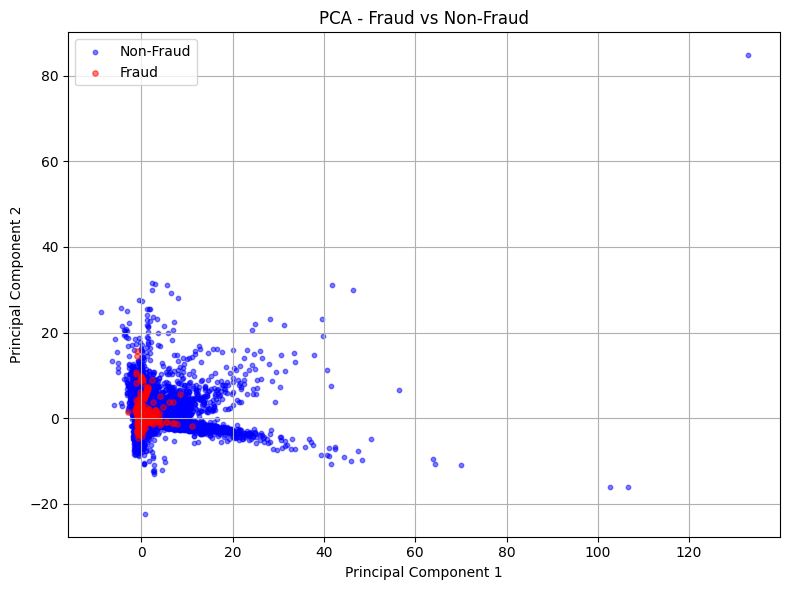

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

features = [col for col in df.columns if col not in ['Class', 'Time']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

labels = df['Class']
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[labels == 0, 0], X_pca[labels == 0, 1], alpha=0.5, label='Non-Fraud', c='blue', s=10)
plt.scatter(X_pca[labels == 1, 0], X_pca[labels == 1, 1], alpha=0.5, label='Fraud', c='red', s=15)
plt.title("PCA - Fraud vs Non-Fraud")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Preprocessing

1. Feature scaling
2. Train-test split

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df.drop(columns=["Class", "Time"])
y = df["Class"]

scaler = StandardScaler()
X["Amount"] = scaler.fit_transform(X[["Amount"]])

#2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


### Logistic Regression - Model Training

In [10]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression model with balanced class weights
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

print("✅ Logistic Regression model trained successfully!")
print(f"Model coefficients shape: {lr_model.coef_.shape}")
print(f"Model intercept: {lr_model.intercept_[0]:.4f}")

# Keep model as 'model' for compatibility with existing code
model = lr_model

✅ Logistic Regression model trained successfully!
Model coefficients shape: (1, 29)
Model intercept: -3.7808


### Evaluation & Visualization

1. Metrics
 - AUPRC
 - ROC-AUC
 - F1 Score
 - Precision
 - Recall
 - Classification Report


In [11]:
from sklearn.metrics import classification_report, precision_recall_curve, roc_auc_score, auc, f1_score, precision_score, recall_score

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
roc_auc = roc_auc_score(y_test, y_prob)

print("AUPRC:", pr_auc)
print("ROC-AUC:", roc_auc)
print("F1 Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


AUPRC: 0.7065637758544517
ROC-AUC: 0.9646709446295834
F1 Score: 0.10479797979797979
Precision: 0.05574210879785091
Recall: 0.8736842105263158

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56651
           1       0.06      0.87      0.10        95

    accuracy                           0.98     56746
   macro avg       0.53      0.92      0.55     56746
weighted avg       1.00      0.98      0.99     56746



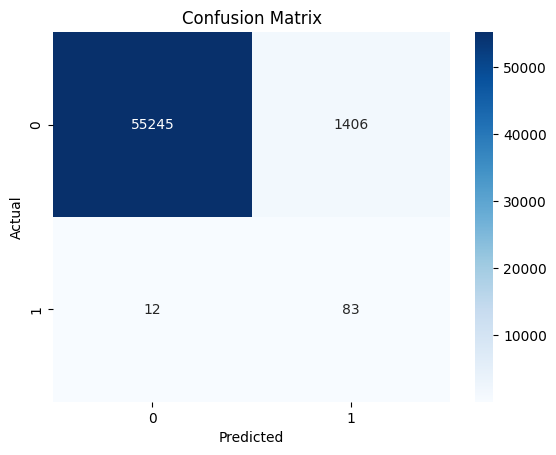

In [12]:
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


ROC Curve (Receiver Operating Characteristic)
The ROC curve plots:

X-axis: False Positive Rate (FPR) = FP / (FP + TN)
Y-axis: True Positive Rate (TPR) = Recall = TP / (TP + FN)
It shows how well the model distinguishes between classes at various thresholds.

Key Metric: AUC-ROC
AUC (Area Under Curve): Measures the overall ability of the model to distinguish fraud from non-fraud.
AUC = 1.0: Perfect classifier
AUC = 0.5: Random guessing



----

Precision-Recall Curve (Recall Curve)
This curve is especially useful for imbalanced datasets like fraud detection.

X-axis: Recall (TP / TP + FN)
Y-axis: Precision (TP / TP + FP)
It shows the trade-off between catching more frauds (recall) and avoiding false alarms (precision).


Key Metric: AUPRC
AUPRC (Area Under Precision-Recall Curve): Higher is better.
More informative than ROC when the positive class (fraud) is rare.

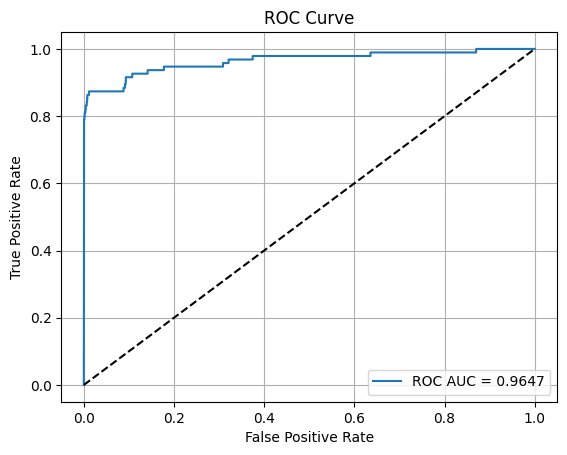

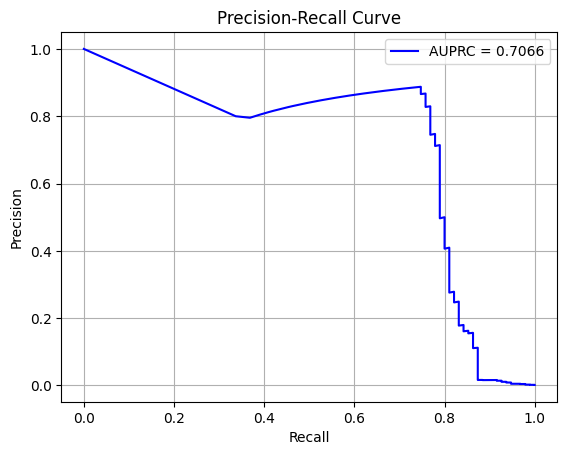

In [13]:
from sklearn.metrics import roc_curve

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Precision-Recall Curve
plt.plot(recall, precision, label=f"AUPRC = {pr_auc:.4f}", color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()


SHAP Values

What Are SHAP Values?
SHAP (SHapley Additive exPlanations) values are a powerful tool for interpreting machine learning models. They explain how much each feature contributed to a particular prediction.

🧠 Intuition Behind SHAP
SHAP is based on game theory — imagine each feature as a "player" in a game, and the model's prediction as the "payout." SHAP calculates how much each feature contributes to the final prediction by considering all possible combinations of features.

📊 What SHAP Tells You
Positive SHAP value: Feature pushes the prediction toward fraud.
Negative SHAP value: Feature pushes the prediction toward non-fraud.
Magnitude: Indicates how strongly the feature influenced the prediction.
📈 Common SHAP Visualizations
Summary Plot: Shows global feature importance and direction of impact.
Force Plot: Visualizes how features push an individual prediction.
Dependence Plot: Shows how a feature’s value affects its SHAP value

In [16]:
!pip install shap

  Using cached cloudpickle-3.1.1-py3-none-any.whl.metadata (7.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.0/548.0 kB 9.1 MB/s eta 0:00:00
Using cached cloudpickle-3.1.1-py3-none-any.whl (20 kB)


Setting up SHAP explainer for Logistic Regression...
✅ SHAP values calculated successfully!
SHAP values shape: (50, 29)

Creating SHAP Summary Plot...


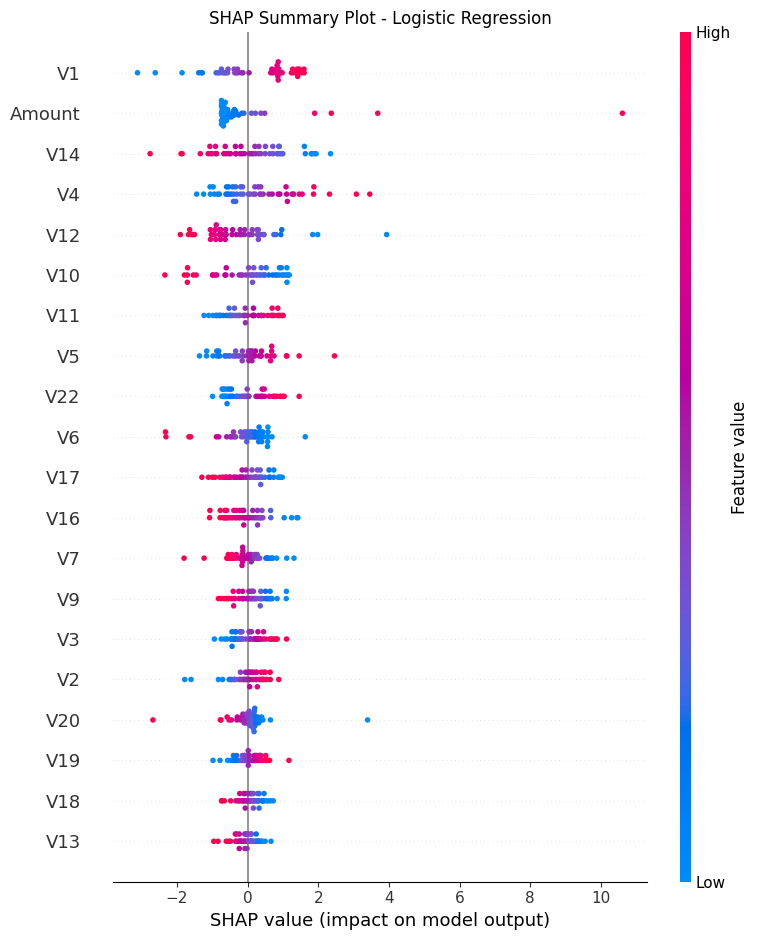


Creating SHAP Feature Importance Plot...


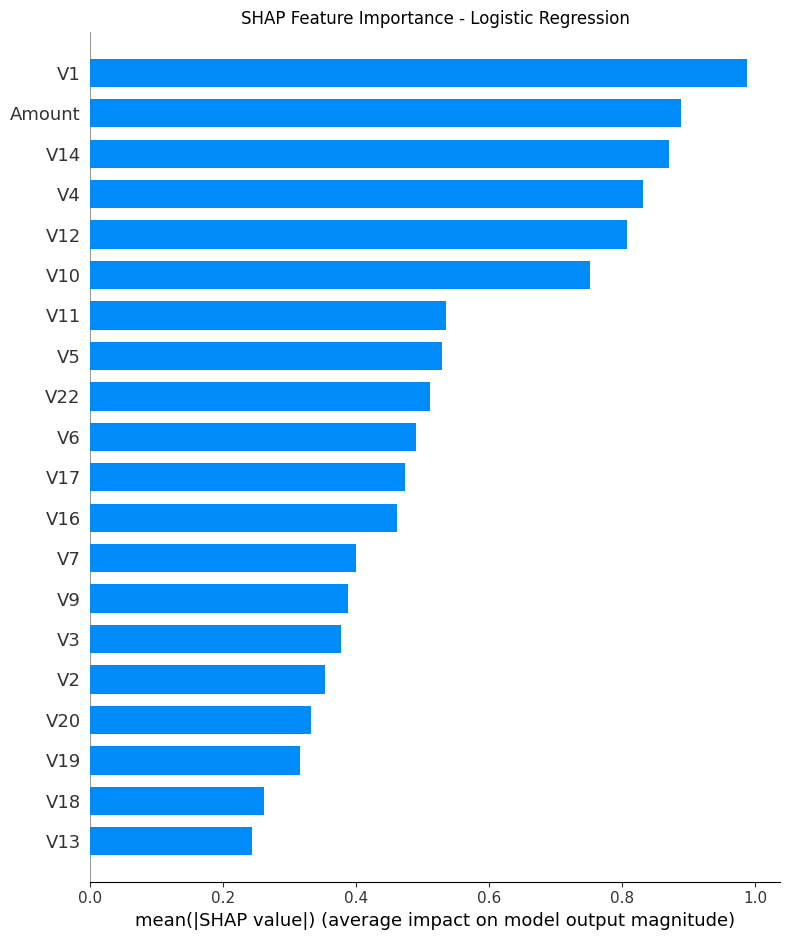

In [17]:
import shap
import matplotlib.pyplot as plt

# Initialize SHAP for Logistic Regression
print("Setting up SHAP explainer for Logistic Regression...")

try:
    # Use a sample of training data as background for faster computation
    background_sample = X_train.sample(min(100, len(X_train)), random_state=42)
    
    # Create explainer for Logistic Regression
    explainer = shap.Explainer(model, background_sample)
    
    # Calculate SHAP values for a subset of test data
    test_sample = X_test.sample(min(50, len(X_test)), random_state=42)
    shap_values = explainer(test_sample)
    
    print("✅ SHAP values calculated successfully!")
    print(f"SHAP values shape: {shap_values.values.shape}")
    
    # Create summary plot
    print("\nCreating SHAP Summary Plot...")
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, test_sample, show=False)
    plt.title("SHAP Summary Plot - Logistic Regression")
    plt.tight_layout()
    plt.show()
    
    # Feature importance plot
    print("\nCreating SHAP Feature Importance Plot...")
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, test_sample, plot_type="bar", show=False)
    plt.title("SHAP Feature Importance - Logistic Regression")
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"❌ Error with SHAP analysis: {e}")
    print("Falling back to simpler feature importance...")
    
    # Fallback: Show coefficient-based feature importance
    import pandas as pd
    feature_importance = abs(model.coef_[0])
    feature_names = X_train.columns
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    import seaborn as sns
    sns.barplot(data=importance_df.head(15), x='importance', y='feature')
    plt.title("Top 15 Feature Importance (Logistic Regression Coefficients)")
    plt.xlabel("Absolute Coefficient Value")
    plt.tight_layout()
    plt.show()

What is LIME?
LIME (Local Interpretable Model-agnostic Explanations) is a technique used to explain the predictions of any machine learning model by approximating it locally with an interpretable model (like linear regression).

🔍 How LIME Works
Pick a prediction you want to explain (e.g., a fraud prediction).
Perturb the input slightly (create similar samples).
Observe how the model's prediction changes.
Fit a simple model (like linear regression) to approximate the complex model locally.
Show which features contributed most to that specific prediction.

In [19]:
!pip install lime

  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283884 sha256=f88c40985a320e6011226fd6c8e3bdaec8d4e8a4cab8e7f0b9d12c36b2e01b3f
  Stored in directory: /Users/rajeshthakur/Library/Caches/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


Setting up LIME explainer for Logistic Regression...


/Users/rajeshthakur/miniconda3/envs/ai_experiments/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/rajeshthakur/miniconda3/envs/ai_experiments/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/rajeshthakur/miniconda3/envs/ai_experiments/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



--- Sample 1 ---
True Label: Normal
Predicted: Normal
Prediction Probability: 0.0180 (Fraud)
Top features contributing to prediction:
  -0.33 < Amount <= -0.27: -0.0902
  V11 <= -0.76: -0.0818
  V9 > 0.59: -0.0691
  0.02 < V1 <= 1.32: 0.0574
  0.14 < V12 <= 0.62: -0.0540
  V18 <= -0.50: 0.0456
  -0.05 < V28 <= 0.01: -0.0401
  V25 > 0.35: -0.0395
  -0.54 < V22 <= 0.01: -0.0330
  -0.21 < V20 <= -0.06: 0.0221


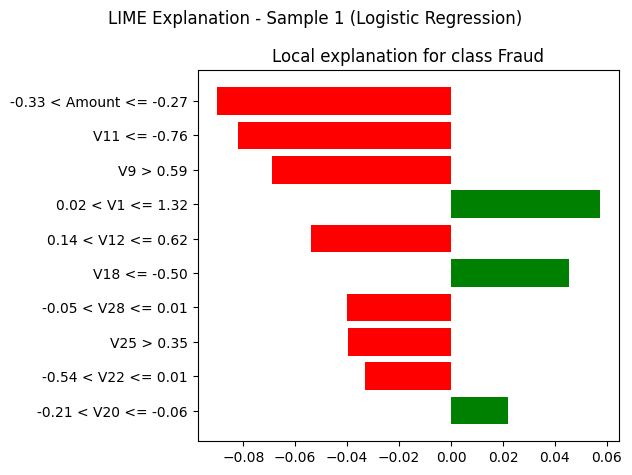


--- Sample 2 ---
True Label: Normal
Predicted: Normal
Prediction Probability: 0.0221 (Fraud)
Top features contributing to prediction:
  V14 > 0.49: -0.1560
  V5 > 0.62: 0.1104
  Amount <= -0.33: -0.0990
  V7 > 0.57: -0.0661
  V11 <= -0.76: -0.0627
  V2 > 0.80: 0.0625
  V22 > 0.53: 0.0590
  -0.85 < V4 <= -0.02: -0.0453
  0.02 < V8 <= 0.33: -0.0384
  -0.92 < V1 <= 0.02: -0.0315


/Users/rajeshthakur/miniconda3/envs/ai_experiments/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/rajeshthakur/miniconda3/envs/ai_experiments/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/rajeshthakur/miniconda3/envs/ai_experiments/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


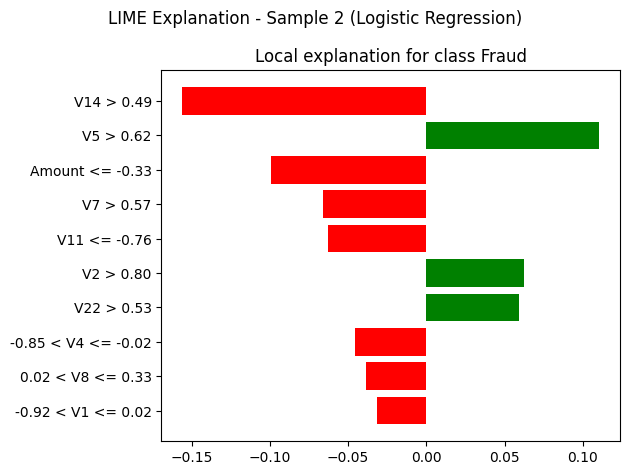

/Users/rajeshthakur/miniconda3/envs/ai_experiments/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/rajeshthakur/miniconda3/envs/ai_experiments/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



--- Sample 3 ---
True Label: Normal
Predicted: Normal
Prediction Probability: 0.0070 (Fraud)


/Users/rajeshthakur/miniconda3/envs/ai_experiments/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Top features contributing to prediction:
  Amount > -0.04: 0.2758
  V14 <= -0.43: 0.2235
  V4 > 0.74: 0.1698
  V1 <= -0.92: -0.1575
  V10 > 0.45: -0.1460
  V17 <= -0.48: 0.0971
  V5 > 0.62: 0.0951
  V20 > 0.13: -0.0870
  V11 > 0.74: 0.0751
  V7 > 0.57: -0.0660


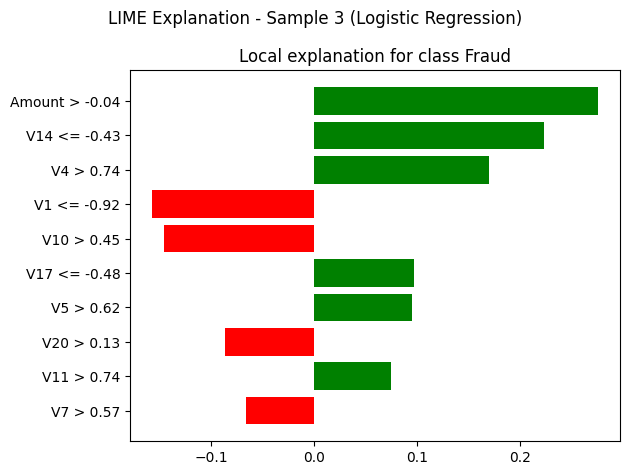

✅ LIME explanations generated successfully!


In [20]:
from lime import lime_tabular
import matplotlib.pyplot as plt

print("Setting up LIME explainer for Logistic Regression...")

try:
    # Create LIME explainer
    explainer = lime_tabular.LimeTabularExplainer(
        X_train.values,
        feature_names=X_train.columns,
        class_names=['Normal', 'Fraud'],
        mode='classification',
        discretize_continuous=True
    )
    
    # Explain a few predictions
    sample_indices = [0, 1, 2, 3, 4]  # First 5 test instances
    
    for i, idx in enumerate(sample_indices):
        instance = X_test.iloc[idx]
        true_label = y_test.iloc[idx]
        predicted_label = lr_model.predict([instance])[0]
        predicted_proba = lr_model.predict_proba([instance])[0]
        
        print(f"\n--- Sample {i+1} ---")
        print(f"True Label: {'Fraud' if true_label == 1 else 'Normal'}")
        print(f"Predicted: {'Fraud' if predicted_label == 1 else 'Normal'}")
        print(f"Prediction Probability: {predicted_proba[1]:.4f} (Fraud)")
        
        # Generate explanation
        explanation = explainer.explain_instance(
            instance.values, 
            lr_model.predict_proba,
            num_features=10
        )
        
        # Show explanation in text
        print("Top features contributing to prediction:")
        for feature, weight in explanation.as_list():
            print(f"  {feature}: {weight:.4f}")
        
        # Plot explanation
        fig = explanation.as_pyplot_figure()
        fig.suptitle(f'LIME Explanation - Sample {i+1} (Logistic Regression)', fontsize=12)
        plt.tight_layout()
        plt.show()
        
        if i >= 2:  # Limit to first 3 examples to avoid too much output
            break
    
    print("✅ LIME explanations generated successfully!")
    
except Exception as e:
    print(f"❌ Error with LIME analysis: {e}")
    print("This could be due to package version compatibility.")
    print("\nAlternative: Showing top feature contributions manually...")
    
    # Simple alternative explanation
    sample_instance = X_test.iloc[0]
    feature_contributions = sample_instance * lr_model.coef_[0]
    top_features = abs(feature_contributions).nlargest(10)
    
    print(f"\nFor first test instance:")
    print(f"Predicted probability of fraud: {lr_model.predict_proba([sample_instance])[0][1]:.4f}")
    print("\nTop 10 contributing features:")
    for feature in top_features.index:
        contribution = feature_contributions[feature]
        value = sample_instance[feature]
        print(f"  {feature}: {contribution:.4f} (value: {value:.4f})")

# KNN classifier

Order of Steps:

- Load & Clean Data
- Exploratory Data Analysis (EDA)
    - Class distribution
    - Time & amount histograms
    - Correlation matrix
- Preprocessing
    - Feature scaling
    - Train-test split
- Model Training (KNN)
- Evaluation & Visualization
- Interpretability (SHAP, LIME)

In [21]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [22]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)


KNeighborsClassifier()

### Evaluation & Visualization
1. Metrics
 - AUPRC
 - ROC-AUC
 - F1 Score
 - Precision
 - Recall
 - Classification Report


In [23]:
from sklearn.metrics import classification_report, precision_recall_curve, roc_auc_score, auc, f1_score, precision_score, recall_score

y_pred = knn.predict(X_test)
y_prob = knn.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
roc_auc = roc_auc_score(y_test, y_prob)

print("AUPRC:", pr_auc)
print("ROC-AUC:", roc_auc)
print("F1 Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


AUPRC: 0.8485513982930736
ROC-AUC: 0.8998954819397438
F1 Score: 0.8242424242424242
Precision: 0.9714285714285714
Recall: 0.7157894736842105

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.97      0.72      0.82        95

    accuracy                           1.00     56746
   macro avg       0.99      0.86      0.91     56746
weighted avg       1.00      1.00      1.00     56746



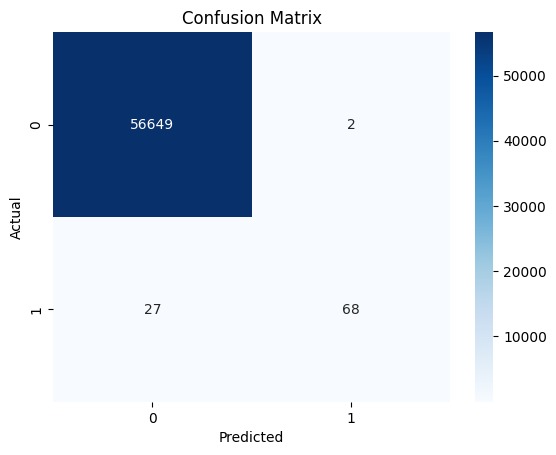

In [24]:
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


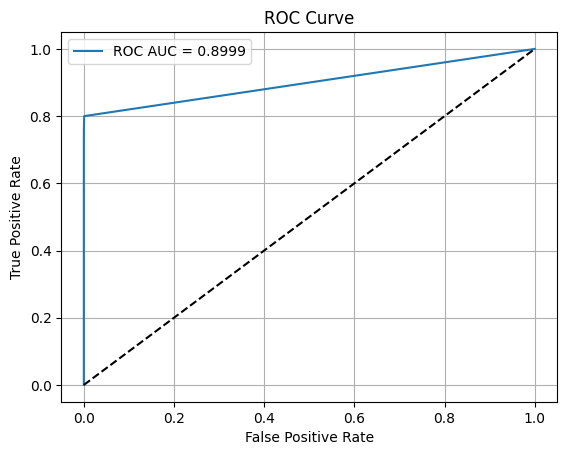

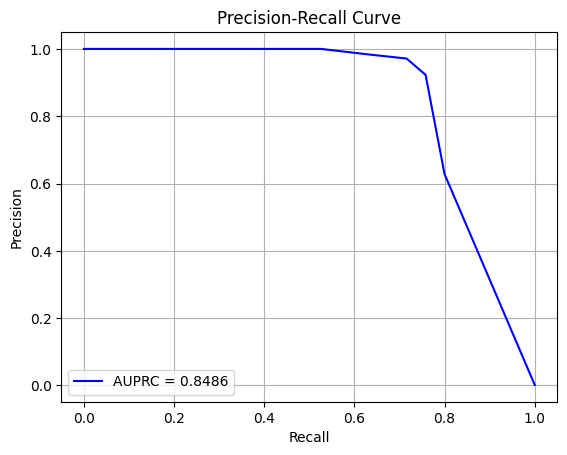

In [25]:
from sklearn.metrics import roc_curve

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Precision-Recall Curve
plt.plot(recall, precision, label=f"AUPRC = {pr_auc:.4f}", color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()


  0%|          | 0/10 [00:00<?, ?it/s]

Shape of X_test.iloc[:10]: (10, 29)
shap_values is a numpy array. Shape: (10, 29, 2)
Shape of shap_values_to_plot (after correct slicing): (10, 29)


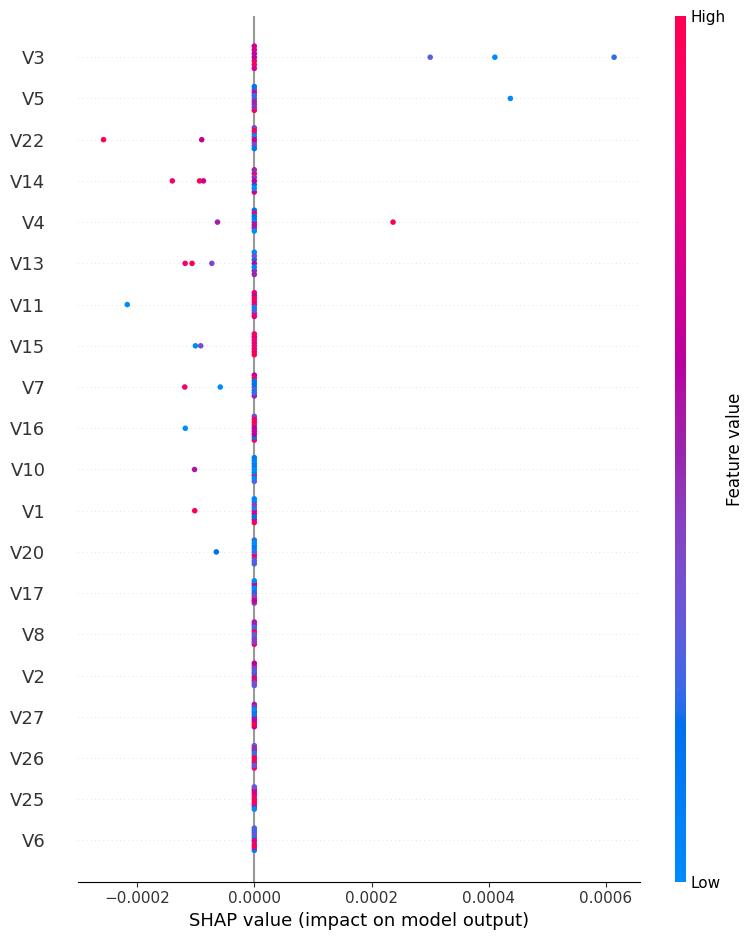

In [26]:
import shap
import matplotlib.pyplot as plt # Ensure plt is imported


# Use a small background sample for efficiency
background = shap.sample(X_train, 100)

# Create KernelExplainer for KNN
# Pass the probability prediction function
explainer = shap.KernelExplainer(knn.predict_proba, background)

# Explain a few test samples
# shap_values will be a list of two arrays for binary classification
# shap_values[0] for class 0, shap_values[1] for class 1
shap_values = explainer.shap_values(X_test.iloc[:10])

print(f"Shape of X_test.iloc[:10]: {X_test.iloc[:10].shape}")
if isinstance(shap_values, list):
    print(f"shap_values is a list. Length: {len(shap_values)}")
    print(f"Shape of shap_values[0]: {shap_values[0].shape}")
    print(f"Shape of shap_values[1]: {shap_values[1].shape}")
else:
    print(f"shap_values is a numpy array. Shape: {shap_values.shape}")

shap_values_to_plot = shap_values[:, :, 1]

print(f"Shape of shap_values_to_plot (after correct slicing): {shap_values_to_plot.shape}")

# Summary plot
shap.summary_plot(shap_values_to_plot, X_test.iloc[:10])

plt.show()

# XGBOOST

In [27]:
!pip install xgboost

  Using cached xgboost-3.0.2-py3-none-macosx_12_0_arm64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.2-py3-none-macosx_12_0_arm64.whl (2.0 MB)


In [28]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_recall_curve,
    roc_auc_score, auc, f1_score, precision_score, recall_score
)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Step 1: Load and Select Important Features
important_features = [
    'V11', 'V4', 'V2', 'V19', 'V8', 'V21', 'V27', 'V20', 'V28',
    'V17', 'V14', 'V12', 'V10', 'V16', 'V7', 'V3', 'V18', 'V1',
    'Amount'  # Keep amount as it's meaningful and not PCA'd
]

X = df[important_features]
y = df["Class"]

# Step 2: Scaling 'Amount'
scaler = StandardScaler()
X["Amount"] = scaler.fit_transform(X[["Amount"]])

# Step 3: Train-Test Split (Stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 4: Train Models
models = {
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Step 5: Evaluate Models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Metrics
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    roc_auc = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    # Report
    print(f"\n=== Evaluation Metrics: {name} ===")
    print(f"AUPRC (Precision-Recall AUC): {pr_auc:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

/var/folders/5g/452dgvq955l5p94xk82bt6x80000gn/T/ipykernel_68788/2535667398.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Amount"] = scaler.fit_transform(X[["Amount"]])



=== Evaluation Metrics: Random Forest ===
AUPRC (Precision-Recall AUC): 0.8251
ROC-AUC: 0.9457
F1 Score: 0.8313
Precision: 0.9718
Recall: 0.7263

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.97      0.73      0.83        95

    accuracy                           1.00     56746
   macro avg       0.99      0.86      0.92     56746
weighted avg       1.00      1.00      1.00     56746



/Users/rajeshthakur/miniconda3/envs/ai_experiments/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [10:08:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Evaluation Metrics: XGBoost ===
AUPRC (Precision-Recall AUC): 0.7405
ROC-AUC: 0.9120
F1 Score: 0.7640
Precision: 0.8193
Recall: 0.7158

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.82      0.72      0.76        95

    accuracy                           1.00     56746
   macro avg       0.91      0.86      0.88     56746
weighted avg       1.00      1.00      1.00     56746



In [29]:
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [30]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Support Vector Machine": SVC(probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

results = []

for name, model in models.items():
    print(f"\n Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    if y_prob is not None:
        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
        pr_auc = auc(recall_vals, precision_vals)
    else:
        pr_auc = float('nan')  # For models like SVM if probability is disabled

    results.append({
        'Model': name,
        'Recall': recall,
        'Precision': precision,
        'F1 Score': f1,
        'AUPRC': pr_auc
    })

# as table

results_df = pd.DataFrame(results).sort_values(by='AUPRC', ascending=False)
# Display the results using plain pandas
print("\n=== Model Evaluation Results (sorted by AUPRC) ===")
print(results_df)


 Training Logistic Regression...

 Training Random Forest...

 Training XGBoost...


/Users/rajeshthakur/miniconda3/envs/ai_experiments/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [10:10:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 Training Support Vector Machine...

 Training K-Nearest Neighbors...

=== Model Evaluation Results (sorted by AUPRC) ===
                    Model    Recall  Precision  F1 Score     AUPRC
4     K-Nearest Neighbors  0.726316   0.971831  0.831325  0.837507
1           Random Forest  0.747368   0.946667  0.835294  0.801523
3  Support Vector Machine  0.621053   0.983333  0.761290  0.769243
2                 XGBoost  0.715789   0.819277  0.764045  0.740546
0     Logistic Regression  0.600000   0.850746  0.703704  0.683777
